## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Make sure to change path if you put the zip elsewhere
#!unzip drive/MyDrive/chest_xray.zip

## Create dataset from directory

In [3]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


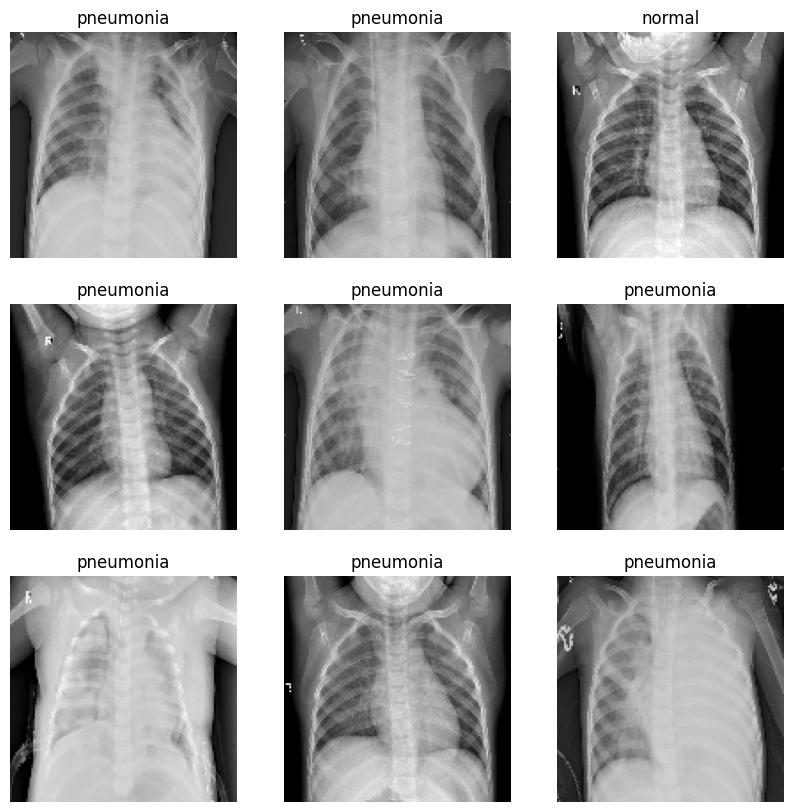

In [4]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [5]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [6]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

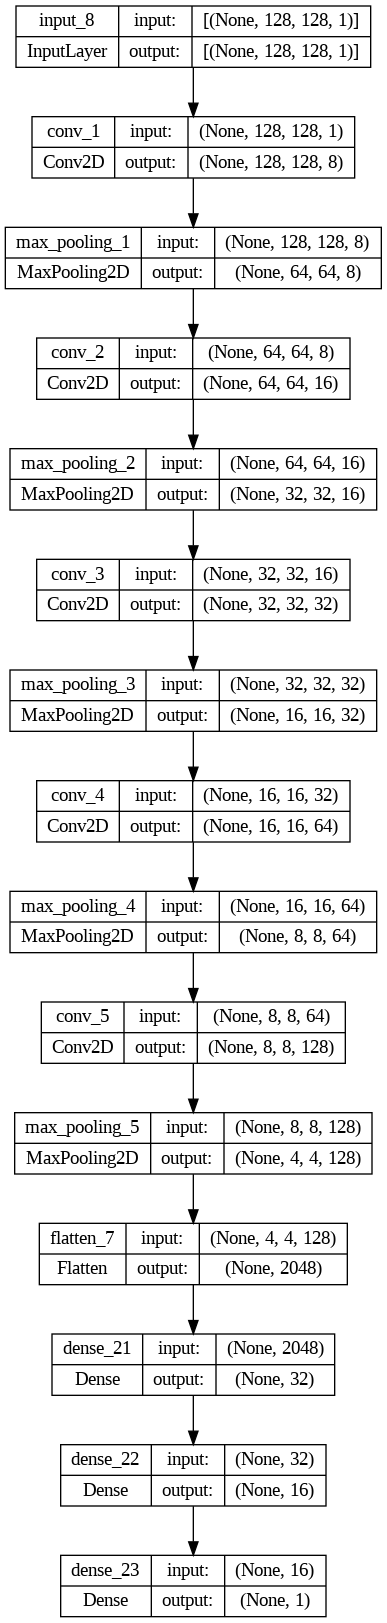

In [7]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses,
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name='input_8')

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.
conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
max_poolling_1 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_1')(conv_1)
conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_poolling_1)
max_poolling_2 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_2')(conv_2)
conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_poolling_2)
max_poolling_3 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_3')(conv_3)
conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_poolling_3)
max_poolling_4 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_4')(conv_4)
conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_poolling_4)
max_poolling_5 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_5')(conv_5)
flatten_7 = Flatten(name='flatten_7')(max_poolling_5)
dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)
dense_23 = Dense(1, activation='sigmoid', name='dense_23')(dense_22)

# activation func of Dense? (2, 2) on Conv2D utility? same on MaxPolling2D ? kernel siz???

cnn = Model(inputs=input, outputs=dense_23)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

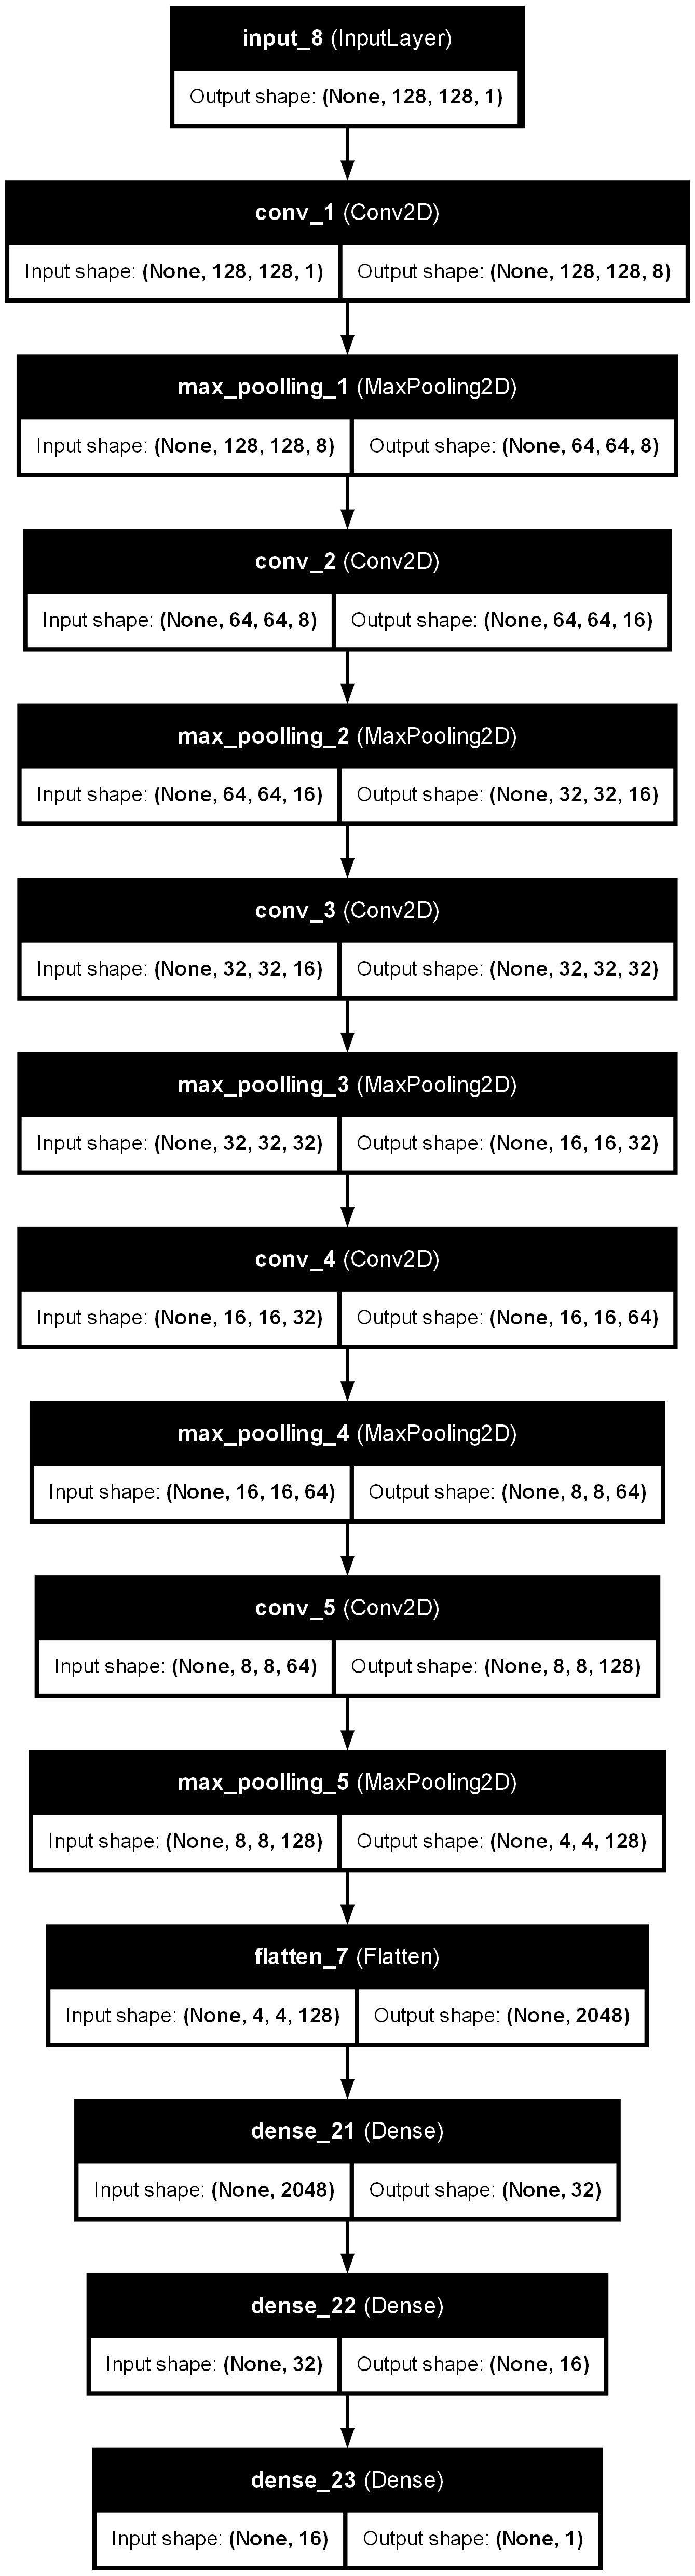

In [8]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [9]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4731 - loss: 1.7333 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5352 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.7041
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.4827 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.7005
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4453 - loss: 0.6908 - val_accuracy: 0.6250 - val_loss: 0.6920
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5031 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6985


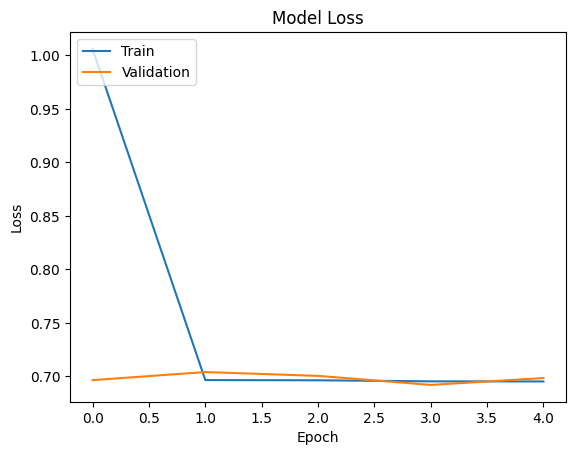

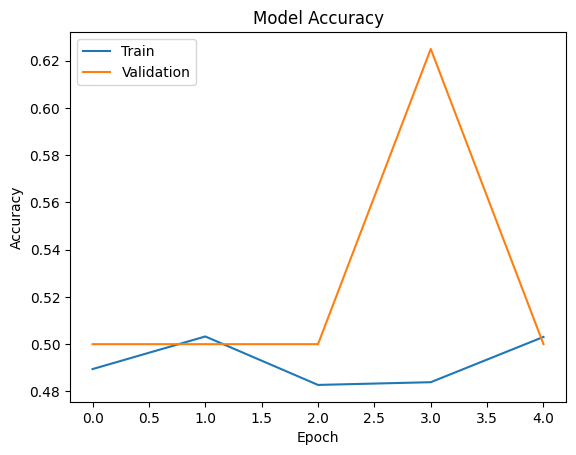

In [10]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set